In [2]:
import pandas as pd
import xgboost as xbg
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.datasets import  make_classification
from itertools import cycle
from keras.utils import to_categorical

2023-02-21 15:24:20.999490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 15:24:21.255950: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-21 15:24:21.255987: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-21 15:24:21.298756: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-21 15:24:22.896198: W tensorflow/stream_executor/pla

In [2]:
# def plot_results(y_test, y_pred, model ):
#     acc = metrics.accuracy_score(y_test, y_pred)
#     f1 = metrics.f1_score(y_test, y_pred, average='macro')
#     y_pred_onehot = pd.get_dummies(y_pred)
#     roc_auc = metrics.roc_auc_score(y_test, y_pred_onehot, multi_class='ovo')
#     print('Model performance for {model}'.format(model=model))
#     print('------------------------------------------------')
#     print('Accuracy is ', acc)
#     print('F1 is ', f1)
#     print('ROC AUC Score is ', roc_auc)
#     print('------------------------------------------------')

#     # metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
#     metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
#     plt.show()
#     df = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))
#     df2 = df.div(df.sum(axis=1), axis=0)
#     ax = sns.heatmap(df2)
#     ax.set(xlabel='Predicted', ylabel='Actual', title=f'Confusion Matrix for {model}')
#     plt.show()
  

In [4]:
def calc_roc_curve(y_test, y_score, classifier):
    if classifier == "1":
        n_classes = 2
    else:
        n_classes = y_test.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

   
    return fpr, tpr, roc_auc, n_classes

In [4]:
# def calc_roc_curve(y_test, y_pred):
#   n_classes = len(np.unique(y_test))
#   y_test = label_binarize(y_test, classes=np.arange(n_classes))
#   y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

#   # Code for MultiClass ROC Curve from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
#   # Compute ROC curve and ROC area for each class
#   fpr = dict()
#   tpr = dict()
#   roc_auc = dict()
#   thresholds = dict()
#   for i in range(n_classes):
#     fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
#     roc_auc[i] = auc(fpr[i], tpr[i])

#   # Compute micro-average ROC curve and ROC area
#   fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
#   roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#   # First aggregate all false positive rates
#   all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#   # Then interpolate all ROC curves at this points
#   mean_tpr = np.zeros_like(all_fpr)
#   for i in range(n_classes):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#   # Finally average it and compute AUC
#   mean_tpr /= n_classes

#   fpr["macro"] = all_fpr
#   tpr["macro"] = mean_tpr
#   roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#   return fpr, tpr, roc_auc, n_classes

In [69]:
# def reorder(y_test, y_pred):
#     #change label 0 to 1 and vice versa
#     y_test = np.where(y_test == 0, 4, y_test)
#     y_test = np.where(y_test == 1, 0, y_test)
#     y_test = np.where(y_test == 4, 1, y_test)

#     y_pred = np.where(y_pred == 0, 4, y_pred)
#     y_pred = np.where(y_pred == 1, 0, y_pred)
#     y_pred = np.where(y_pred == 4, 1, y_pred)

#     return y_test, y_pred

In [17]:
def plot_results_b(y_test, y_pred, model, perf_class, classifier="2"):
    if classifier == "1":
        labels = {0: "Non-Covid", 1: "Covid"}
    elif classifier == "2":
        labels = {0: "Anti-Vaccine", 1: "Neutral", 2: "Pro-Vaccine"}
    fig = plt.figure(f"{model} Performance Evaluation", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)
    font = {"weight": "bold"}
    fpr, tpr, roc_auc, n_classes = calc_roc_curve(y_test, y_pred, classifier)
    ax0 = fig.add_subplot(axgrid[0:3, :])

    ax0.set_title(f"Receiver Operating Characteristic (ROC) Curve for {model}", fontdict=font)
     # Plot all ROC curves
    # ax0.figure(figsize=(3,3))
    # ax0.figure(dpi=600)
    lw = 2

     # Plot all ROC curves
    ax0.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    ax0.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        ax0.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(labels[i], roc_auc[i]),
        )

    ax0.plot([0, 1], [0, 1], "k--", lw=lw)
    ax0.set_xlim([0.0, 1.0])
    ax0.set_ylim([0.0, 1.05])
    ax0.set_xlabel("False Positive Rate")
    ax0.set_ylabel("True Positive Rate")
   
    ax0.legend(loc="lower right")

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.set_title("Confusion Matrics", fontdict=font)
    y_score_max = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
    y_score_label = np.argmax(y_score_max, axis=1)
    y_test_label = np.argmax(y_test, axis=1)
    df = pd.DataFrame(metrics.confusion_matrix(y_test_label, y_score_label))
    df2 = df.div(df.sum(axis=1), axis=0)
    ax1 = sns.heatmap(df2, annot=True)
    ax1.set(xlabel='Predicted', ylabel='Actual', xticklabels=labels.values(), yticklabels=labels.values())
    ax1.set_title("Confusion matrix", fontdict=font)

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    acc = metrics.accuracy_score(y_test_label, y_score_label)
    f1 = metrics.f1_score(y_test_label, y_score_label, average='macro')
    roc_auc = metrics.roc_auc_score(y_test, y_score_max, multi_class='ovo')
    ax2.set_title("Performance Metrics", fontdict=font )
    ax2.text(0.23, 0.85, f"Model: {model}", fontdict=font)
    ax2.text(0.23, 0.75, f"Model Type: {perf_class}")
    ax2.text(0.18, 0.68, "--------------------------------------------------")
    ax2.text(0.23, 0.6, f"Accuracy is {round(acc, 3)}")
    ax2.text(0.23, 0.5, f"F1 is {round(f1,3)}")
    ax2.text(0.23, 0.4, f"ROC-AUC is {round(roc_auc, 3)}")
    ax2.text(0.18, 0.33, "---------------------------------------------------")
    # ax2.text(0.23, 0.25, "Label Legend: ", fontdict=font )
    
    # ax2.text(0.23, 0.15, "Class 0: Anti-Vaccine")
    # ax2.text(0.23, 0.05, "Class 1: Neutral / Noise")
    # ax2.text(0.23, -0.05, "Class 2: Pro-Vaccine")
  
    ax2.set_axis_off()

    fig.tight_layout()
    # plt.savefig(f'../../Visualizations/Classifier/C{classifier}_{model[0:4]}.pdf', bbox_inches='tight')
    plt.show()
    

## Classifier I

In [32]:
y_true = pd.read_csv('../../Files/Submissions/train/test1.csv', sep='|')
y_true = to_categorical(y_true['label'], 2)

### XGBoost

In [33]:
y_true.shape

(2743, 2)

In [5]:
y_pred_xgb = np.loadtxt('../../Files/models/xgboostC1.txt')
y_pred_xgb = y_pred_xgb.reshape(2743, 2)

In [6]:
import scikitplot as skplt

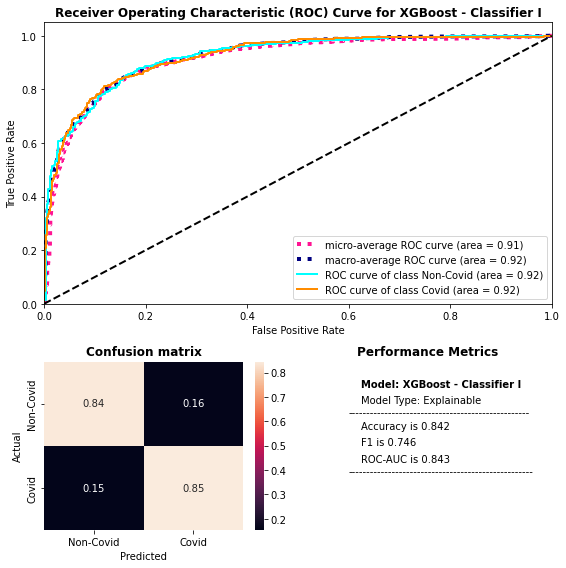

In [13]:
plot_results_b(y_true, y_pred_xgb, "XGBoost - Classifier I", "Explainable", "1")

### CNN

In [35]:
y_pred_cnn = np.loadtxt('../../Files/models/cnn_C1_results.txt')
y_pred_cnn = y_pred_cnn.reshape(2743, 2)
y_pred_cnn.shape

(2743, 2)

In [15]:
y_score_max = (y_pred_cnn == y_pred_cnn.max(axis=1)[:,None]).astype(int)
y_score_label = np.argmax(y_score_max, axis=1)
y_test_label = np.argmax(y_true, axis=1)

<AxesSubplot:>

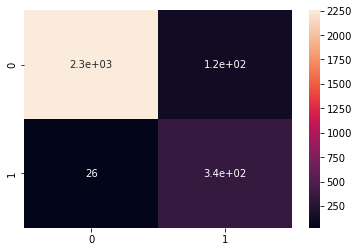

In [16]:
df = pd.DataFrame(metrics.confusion_matrix(y_test_label, y_score_label))
sns.heatmap(df, annot=True)

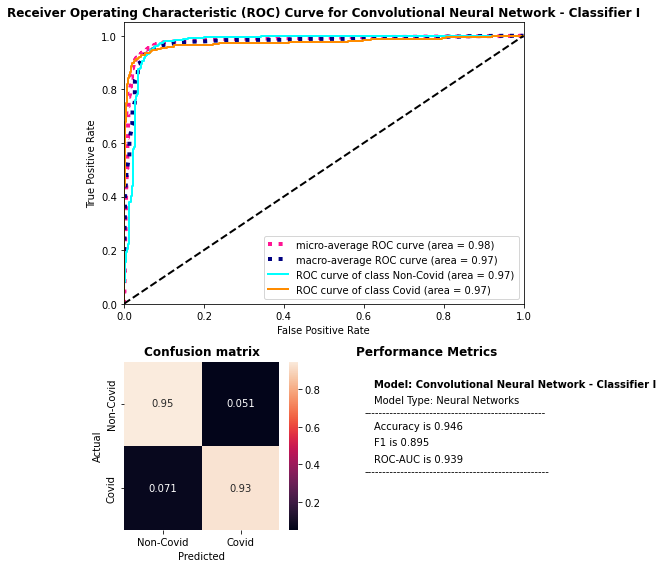

In [36]:
plot_results_b(y_true, y_pred_cnn, "Convolutional Neural Network - Classifier I", "Neural Networks", "1")

## Classifier II

In [6]:
y_true = pd.read_csv('../../Files/Submissions/train/test2_v2.csv', sep='|')
y_true = to_categorical(y_true['label'], 3)

In [19]:
df2 = pd.read_csv('../../Files/Submissions/train/test2_v2.csv', sep='|')

In [29]:
df2.groupby(by='label').count()

,id,text,url,score,title,author,selftext,permalink,subreddit,created_utc,num_comments,Comments,cleanText
label,,,,,,,,,,,,,
0,145,145,145,145,145,145,57,145,145,145,145,0,145
1,177,177,177,177,177,177,33,177,177,177,177,1,177
2,139,139,139,139,139,139,59,139,139,139,139,0,139


In [30]:
len(df2)

461

### Explainable

#### XGBOOST

In [20]:
y_pred_xgb = np.loadtxt('../../Files/models/xgb_Proba_v3.txt')


In [21]:
y_true.shape

(461, 3)

In [22]:
y_pred_xgb = y_pred_xgb.reshape(461, 3)

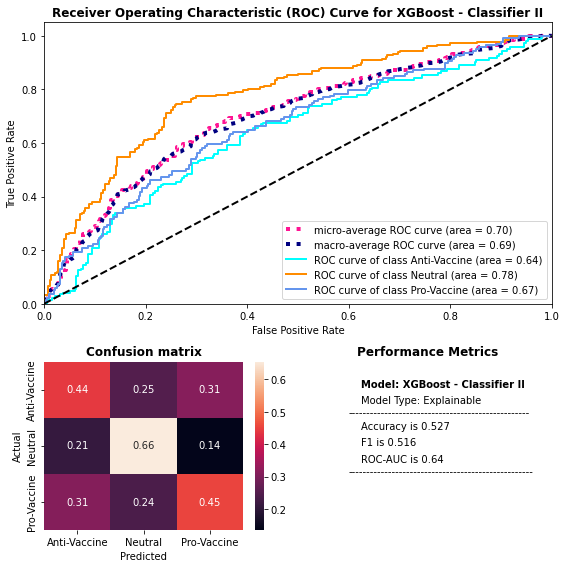

In [23]:
plot_results_b(y_true, y_pred_xgb, "XGBoost - Classifier II", "Explainable", "2")

### NN

#### CNN

In [24]:
y_pred_cnn = np.loadtxt('../../Files/models/cnn_comments_results.txt')
y_pred_cnn = y_pred_cnn.reshape(368, 3)
y_pred_cnn.shape

(368, 3)

In [25]:
plot_results_b(y_true, y_pred_cnn, "CNN - Classifier II", "Neural Networks", "2")

ValueError: Found input variables with inconsistent numbers of samples: [461, 368]

<Figure size 576x576 with 0 Axes>

#### RoBERTa

In [9]:
y_pred = pd.read_csv('../../Files/models/Roberta_C2_v2.csv', sep='|')['pred_1']

In [11]:
y_pred.shape

(461, 18)

In [13]:
tests_1hot = to_categorical(y_pred )

In [19]:
y_true

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
y_conf = pd.read_csv('../../Files/Submissions/train/Roberta_C2_v5.csv', sep='|')[['conf_0', 'conf_1', 'conf_2']]

In [14]:
y_pred_roberta = y_conf.to_numpy()

In [24]:
b

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [23]:
b = np.zeros_like(y_pred_roberta)
b[np.arange(len(y_pred_roberta)), y_pred_roberta.argmax(1)] = 1

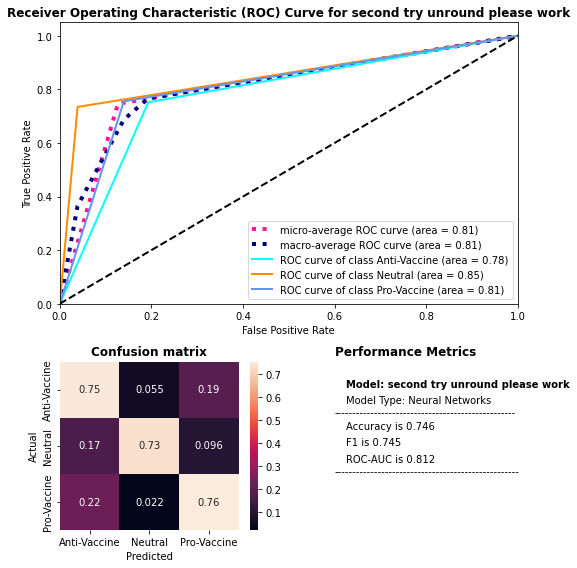

In [25]:
plot_results_b(y_true, b, "second try unround please work", "Neural Networks", "2")

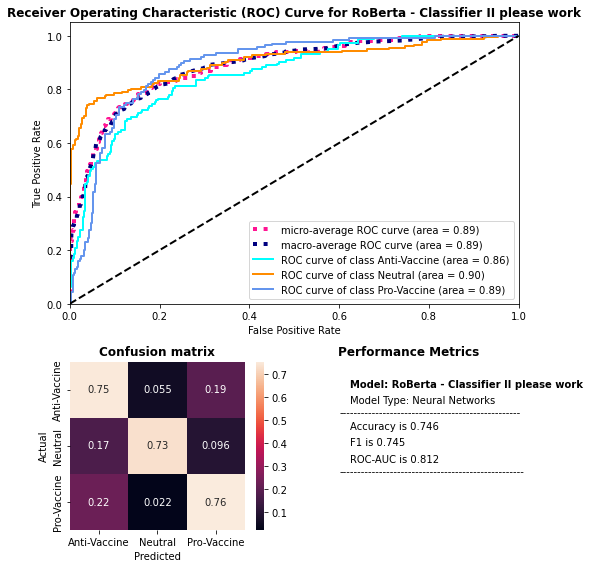

In [18]:
plot_results_b(y_true, y_pred_roberta, "RoBerta - Classifier II please work", "Neural Networks", "2")

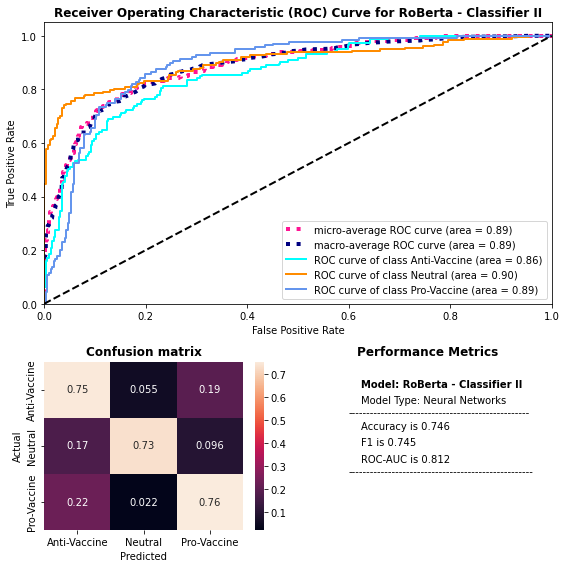

In [30]:
plot_results_b(y_true, y_pred_roberta, "RoBerta - Classifier II", "Neural Networks", "2")

# DEPRECATED: FIRST TRAINED CLASSIFIER

## Explainable Models

### Linear Regression

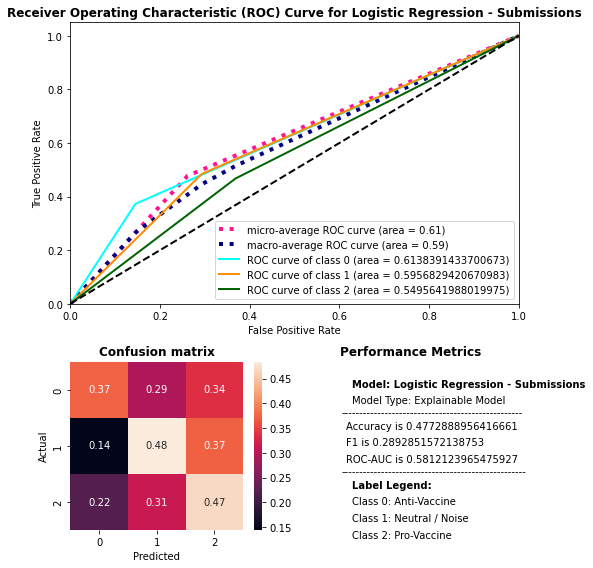

In [160]:
plot_results_b(y_true, y_pred, 'Logistic Regression - Submissions', "Explainable Model")

### XGBoost

In [157]:
y_pred = np.fromfile('../../Files/models/xgb_test.txt', sep=' ')

In [104]:
y_pred.shape

(1408474,)

## Neural Networks

### CNN

In [155]:
y_pred = np.loadtxt('../../Files/models/cnn_results.txt')
y_pred = y_pred.reshape(1408474, 3)
y_pred = y_pred.round()
y_pred = np.argmax(y_pred, axis=1)

In [161]:
y_pred = np.loadtxt('../../Files/models/cnn_results2.txt')

### Pre-trained BERT: BERT base cased

In [80]:
df = pd.read_pickle('../../Files/models/bert_base_cased_model/fully_trained/bert_base_cased_predictions.pickle')

In [98]:
y_pred = []
for i, j in df.iterrows():
    y_pred.append(int(df[0][i]['label'][-1]))

In [ ]:
y_true, y_pred = reorder(y_true, y_pred)

### BERT 2

In [115]:
df = pd.read_pickle('../../Files/models/bert_base_cased_model/fully_trained/bert_base_cased_predictions2.pickle')

In [130]:
y_pred = []
for i, j in df.iterrows():
    y_pred.append(int(df[0][i]['label'][-1]))

In [151]:
y_true = pd.read_csv('../../Files/models/y_true.csv')
y_true.reset_index(drop=True, inplace=True)
y_true = y_true.to_numpy()
y_true = y_true.flatten()

In [134]:
y_pred = np.where(y_pred == 0, 4, y_pred)
print("done")

done


In [136]:
y_pred = np.where(y_pred == 1, 0, y_pred)
print("done")
y_pred = np.where(y_pred == 4, 1, y_pred)


done


In [137]:
np.unique(y_pred)

array([0, 1, 2])

In [144]:
y_true = np.where(y_true == 0, 4, y_true)
y_true = np.where(y_true == 1, 0, y_true)
y_true = np.where(y_true == 4, 1, y_true)

In [145]:
np.unique(y_true)

array([0, 1, 2])

### pre-trained Twitter RoBERTa Submissions

In [147]:
df = pd.read_pickle('/Users/jakobschlierf/Desktop/Master/Thesis/Files/models/chp43125s.pickle')

### pre-trained Twitter RoBERTa Comments

In [63]:
df2 = pd.read_pickle('/Users/jakobschlierf/Desktop/Master/Thesis/Files/models/chp63750.pickle')

In [ ]:
def drawPieMarker(xs, ys, ratios, sizes, colors):

    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'



    markers = []

    previous = 0

    # calculate the points of the pie pieces

    for color, ratio in zip(colors, ratios):

        this = 2 * np.pi * ratio + previous

        x  = [0] + np.cos(np.linspace(previous, this, 50)).tolist() + [0]

        y  = [0] + np.sin(np.linspace(previous, this, 50)).tolist() + [0]

        xy = np.column_stack([x, y])

        previous = this

        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color, 'edgecolor': 'k', 'linewidth':.1})

    # scatter each of the pie pieces to create pies

    for marker in markers:

        ax.scatter(xs, ys, **marker)

node = 'United States'

x, y = pos[node]

size = pure_degrees.loc[node,'weighted_degree'] + 10




fig, ax = plt.subplots(1,1, figsize=(3,3))

ax.set_facecolor('lightgray')

drawPieMarker(xs=x,

            ys=y,

            ratios= pure_degrees_pct.loc[node],

            sizes=[size],

            colors=colors)

In [ ]:
import netwulf as nw
# FIND COMMUNIY STRUCTURE
from community import community_louvain
# function to find communities
def find_communities(G, weight = 'weight'):
    # compute the best partition
    partition = community_louvain.best_partition(G, weight = weight)
    # modularity
    mod = community_louvain.modularity(partition, G, weight = weight)
    # save partition in the graph
    nx.set_node_attributes(G, partition, 'group')
    print(f" Modularity: {round(mod, 3)} \n Communities: {len(Counter(partition.values()))}")
    return partition, mod
# apply it to the graph
# partition, mod = find_communities(G_related)
config = None #new_config
def plot_graph(G,
               edge_weight_key='weight',
               node_group_key = 'group',
               figsize = (15,15),
               config = config,
               savefig_name = None, fig = None, axes = None):
    # intialize the attributes to plot in color the partition 
    new_G = nw.get_filtered_network(G, edge_weight_key= edge_weight_key, node_group_key = node_group_key)
    stylized_network, new_config = nw.visualize(new_G, config = config, plot_in_cell_below = False, is_test=False) 
    if fig is None:
        fig, axes = plt.subplots(figsize = figsize)
    nw.draw_netwulf(stylized_network, fig = fig, ax = axes ,figsize = figsize, draw_nodes = True)
    # save the position of the nodes in a (x,y) format
    pos = { n: array(nw.tools.node_pos(stylized_network, n)) for n in G.nodes() if n!= np.nan}
    # create label for eache node, with the size proportional to the degree of the node
    for node_style in stylized_network['nodes']:
        label = node_style['id']
        x,y  = nw.tools.node_pos(stylized_network, label)
        size = 1+ 3*log(node_style['radius'])
        axes.text(x,y,label, size =size,
                  horizontalalignment='center',
                  verticalalignment='center', zorder = 1000)
    # save figure if you like
    if savefig_name is not None:
        plt.savefig(f'{savefig_name}.pdf', bbox_inches = 'tight')
    return stylized_network, new_config
th = .1
fig, axes = plt.subplots(3,2, figsize = (18,30))
axes = axes.flatten()
for i, a in enumerate(antigens):
    axes[i].set_title(a)
    axes[i].axis('off')
    axes[i].set_facecolor("white")
    G_disparity = bd.disparity_filter(ra_networks_by_antigen[a].subgraph(top_30), weight = 'weight')
    print(nx.info(G_disparity)) 
    temp_g = bd.disparity_filter_alpha_cut(G_disparity, alpha_t = th)
    new_config = None
    stylized_network, new_config = nw.visualize(temp_g,config = new_config, plot_in_cell_below = True, is_test=False)
    pos = { n: array(nw.tools.node_pos(stylized_network, n)) for n in temp_g.nodes() if n!= np.nan}
    nw.tools.bind_properties_to_network(temp_g,stylized_network)
    edge_width = list(nx.get_edge_attributes(temp_g,'width').values())
    # nx.set_node_attributes(temp_g,nodes_info.reset_index().to_dict('index'))
    e_other = nx.draw_networkx_edges(temp_g,
                                    edge_color = 'gray',
                                    pos=pos,
                                    connectionstyle=f'arc3, rad = .1', width = edge_width, alpha = 0.2, ax=axes[i])
    n = nx.draw_networkx_nodes(temp_g, pos = pos,node_size = 4*np.pi*array(list(nx.get_node_attributes(temp_g,'radius').values())), edgecolors= 'k',ax=axes[i])#[100*log1p(deg) for deg in d.values()])
    if len(temp_g)<100:
        l = nx.draw_networkx_labels(temp_g, pos, font_size= 8,ax=axes[i])
    # partition, mod = find_communities(temp_g)
    # stylized_network, new_config = plot_graph(temp_g, savefig_name = None, fig = fig, axes= axes[i], config=new_config)